In [1]:
from collect_data import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio

from transformers import AutoFeatureExtractor, ClapModel, ClapProcessor, ClapAudioModel
from transformers import AutoProcessor, Wav2Vec2Model
from torch.optim import AdamW, Adam
from torch.utils.data import DataLoader, Dataset


/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
stimuli_path = meg_path + '/stimuli/audio'
patient = ['01']
sub_decim = 10
brain_signal_data = []
audio_signal_data = []
# raw = get_bids_raw(meg_path, patient[0], session[0], '0')

In [3]:
for subject in tqdm(patient):
    print('PATIENT: ', subject)
    for sess in range(len(session)):
        print("SESSION: ", session[sess])
        for story in task_list:
            print('AUDIO_NAME: ', story)
            selected_sound_ids = tasks_with_sound_ids[story]
            story_uid = int(task[story])
            print("STORY_UID: ", story_uid)
            raw = get_bids_raw(meg_path, subject, session[sess], str(story_uid))
            for z, sound_id in enumerate(selected_sound_ids):
                print("SOUND_ID: ", float(sound_id))
                epochs_data = get_epochs(raw, float(story_uid), float(sound_id), sub_decim)
                epoch_signal = get_meg_from_raw_epochs(epochs_data)
                print('MEG_SHAPE: ', epoch_signal.shape)
                brain_signal_data.append(epoch_signal)
                data_audio_chunks = []
                audio_path = stimuli_path + '/' + story + '_' + str(z) + '.wav'
                # save_data(meg_spectr_ranged, 'megsp', subject, str(i), str(story_uid), audio_name, str(z))
                if subject == '01':
                    for j in range(epoch_signal.shape[0]):
                        start = epochs_data[j]._metadata["start"].item()
                        y, sr = librosa.load(audio_path, sr=sampling_audio, offset=start, duration=duration)
                        if (y.shape[0] < duration*sampling_audio):           
                            pad_width = duration*sampling_audio - y.shape[0]
                            y = np.pad(y, (0, pad_width), mode='constant', constant_values=0)
                        data_audio_chunks.append(y)
                    audio_tensor_chunk = torch.tensor(data_audio_chunks)
                    print('AUDIO_SHAPE: ', audio_tensor_chunk.shape)
                    audio_signal_data.append(audio_tensor_chunk)
                    # save_data(audio_spectr, 'audio', 'audio', '_', str(story_uid), audio_name, str(z))

  0%|          | 0/1 [00:00<?, ?it/s]

PATIENT:  01
SESSION:  0
AUDIO_NAME:  lw1
STORY_UID:  0
Reading 0 ... 395999  =      0.000 ...   395.999 secs...


/home/matteoc/spect-to-meg/code/collect_data.py:57: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (6.601 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
SOUND_ID:  0.0
Adding metadata with 18 columns
180 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 180 events and 3201 original time points (prior to decimation) ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
MEG_SHAPE:  torch.Size([180, 208, 321])
SOUND_ID:  1

/tmp/ipykernel_2085341/894240195.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  audio_tensor_chunk = torch.tensor(data_audio_chunks)


0 bad epochs dropped
Applying baseline correction (mode: mean)
MEG_SHAPE:  torch.Size([139, 208, 321])
SOUND_ID:  2.0
Adding metadata with 18 columns
225 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 225 events and 3201 original time points (prior to decimation) ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
MEG_SHAPE:  torch.Size([225, 208, 321])
SOUND_ID:  3.0
Adding metadata with 18 columns
124 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 124 events and 3201 original time points (prior to decimation) ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
MEG_SHAPE:  torch.Size([124, 208, 321])
AUDIO_NAME:  cable_spool_fort
STORY_UID:  1
Reading 0 ... 715999  =      0.000 ...   715.999 secs...


/home/matteoc/spect-to-meg/code/collect_data.py:57: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (6.601 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
SOUND_ID:  0.0
Adding metadata with 18 columns
300 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 300 events and 3201 original time points (prior to decimation) ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
MEG_SHAPE:  torch.Size([300, 208, 321])
SOUND_ID:  1

/home/matteoc/spect-to-meg/code/collect_data.py:57: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (6.601 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
SOUND_ID:  0.0
Adding metadata with 18 columns
257 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 257 events and 3201 original time points (prior to decimation) ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
MEG_SHAPE:  torch.Size([257, 208, 321])
SOUND_ID:  1

/home/matteoc/spect-to-meg/code/collect_data.py:57: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (6.601 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
SOUND_ID:  0.0
Adding metadata with 18 columns
358 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 358 events and 3201 original time points (prior to decimation) ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
MEG_SHAPE:  torch.Size([358, 208, 321])
SOUND_ID:  1

/home/matteoc/spect-to-meg/code/collect_data.py:57: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (6.601 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
SOUND_ID:  0.0
Adding metadata with 18 columns
180 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 180 events and 3201 original time points (prior to decimation) ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
MEG_SHAPE:  torch.Size([180, 208, 321])
SOUND_ID:  1

/home/matteoc/spect-to-meg/code/collect_data.py:57: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (6.601 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
SOUND_ID:  0.0
Adding metadata with 18 columns
300 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 300 events and 3201 original time points (prior to decimation) ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
MEG_SHAPE:  torch.Size([300, 208, 321])
SOUND_ID:  1

/home/matteoc/spect-to-meg/code/collect_data.py:57: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (6.601 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
SOUND_ID:  0.0
Adding metadata with 18 columns
257 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 257 events and 3201 original time points (prior to decimation) ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
MEG_SHAPE:  torch.Size([257, 208, 321])
SOUND_ID:  1

/home/matteoc/spect-to-meg/code/collect_data.py:57: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (6.601 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
SOUND_ID:  0.0
Adding metadata with 18 columns
358 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 358 events and 3201 original time points (prior to decimation) ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
MEG_SHAPE:  torch.Size([358, 208, 321])
SOUND_ID:  1

100%|██████████| 1/1 [19:40<00:00, 1180.74s/it]


In [2]:
def split_tensor(tensor, train_ratio=0.8):
    total_samples = tensor.size(0)
    train_size = int(total_samples * train_ratio)
    train_tensor = tensor[:train_size]
    test_tensor = tensor[train_size:]
    return train_tensor, test_tensor

In [ ]:
audio_signal_data_tensor = torch.cat(audio_signal_data, dim=0)
audio_train, audio_test = split_tensor(audio_signal_data_tensor)
# torch.save(audio_train, '/data01/data/MEG/collect_data/audio/audio_tensor_train_raw.pt')
# torch.save(audio_test, '/data01/data/MEG/collect_data/audio/audio_tensor_test_raw.pt')

brain_signal_data_tensor = torch.cat(brain_signal_data, dim=0)
brain_train, brain_test = split_tensor(brain_signal_data_tensor)
# torch.save(brain_train, '/data01/data/MEG/collect_data/megt/brain_tensor_train_raw.pt')
# torch.save(brain_test, '/data01/data/MEG/collect_data/megt/brain_tensor_test_raw.pt')


In [3]:
audio_train = torch.load('/data01/data/MEG/collect_data/audio/audio_tensor_train_raw.pt')
audio_test = torch.load('/data01/data/MEG/collect_data/audio/audio_tensor_test_raw.pt')
brain_train = torch.load('/data01/data/MEG/collect_data/megt/brain_tensor_train_raw.pt')
brain_test = torch.load('/data01/data/MEG/collect_data/megt/brain_tensor_test_raw.pt')

In [4]:
audio_train.shape, brain_train.shape

(torch.Size([13697, 48000]), torch.Size([13697, 208, 321]))

## Ridge model on Himalaya

In [5]:
from himalaya.ridge import RidgeCV
from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.backend import set_backend

X=audio_train.numpy()
y=brain_train.numpy().reshape(13697, -1)
# y=brain_train.numpy()

device_id = 2  # Change this to your desired GPU index
torch.cuda.set_device(device_id)  # Set the current device

backend = set_backend("torch_cuda")
X = backend.asarray(X).to(f'cuda:{device_id}')
y = backend.asarray(y).to(f'cuda:{device_id}')

# array_1 = []
# array_2 = []
# for i in tqdm(range(208)):
vm=KernelRidgeCV(alphas=[0.01,1,10,1e2])
vm.fit(X,y)
voxels_scores=vm.score(X,y)
predict=vm.predict(X)



In [8]:
predict.shape

torch.Size([13697, 66768])

## Inference CLAP 

In [7]:
clap_model_id="laion/larger_clap_music_and_speech"
device_id = 5
feature_extractor = AutoFeatureExtractor.from_pretrained(clap_model_id)
model = ClapAudioModel.from_pretrained("laion/clap-htsat-fused").to(f'cuda:{device_id}')
processor = AutoProcessor.from_pretrained("laion/clap-htsat-fused")
resampler = torchaudio.transforms.Resample(orig_freq=sampling_audio, new_freq=48000)

audio_feat_train = []
with torch.no_grad():
    for wv in tqdm(list(zip(audio_train))):
        wv_tensor = wv[0].float()
        wv = resampler(wv_tensor)
        inputs = processor(audios=wv, return_tensors="pt", sampling_rate=48_000)
        outputs = model(**inputs.to(f'cuda:{device_id}'))
        last_hidden_state = outputs.last_hidden_state.to('cpu')
        audio_feat_train.append(last_hidden_state)
    # for wv in tqdm.tqdm(audio_tensor_train):
    #     wv = resampler(wv)
    #     inputs = feature_extractor(wv.squeeze(), return_tensors="pt",sampling_rate=48_000)
    #     audio_features = model.get_audio_features(inputs.input_features.to("cuda:0"))
    #     audio_features = audio_features.cpu()
    #     audio_feat_train.append(audio_features)
    audio_feat_train=torch.stack(audio_feat_train).squeeze()

Some weights of ClapAudioModel were not initialized from the model checkpoint at laion/clap-htsat-fused and are newly initialized: ['audio_encoder.layers.2.blocks.2.layernorm_after.bias', 'audio_encoder.layers.2.blocks.5.attention.self.relative_position_bias_table', 'audio_encoder.layers.2.blocks.0.intermediate.dense.weight', 'audio_encoder.layers.1.blocks.1.attention.self.key.weight', 'audio_encoder.layers.2.blocks.1.layernorm_before.bias', 'audio_encoder.layers.3.blocks.0.attention.self.key.bias', 'audio_encoder.layers.0.blocks.1.attention.output.dense.bias', 'audio_encoder.patch_embed.fusion_model.local_att.1.running_var', 'audio_encoder.layers.2.blocks.2.output.dense.bias', 'audio_encoder.layers.2.blocks.5.output.dense.bias', 'audio_encoder.layers.2.blocks.0.intermediate.dense.bias', 'audio_encoder.layers.2.blocks.2.attention.self.query.bias', 'audio_encoder.layers.2.blocks.4.layernorm_after.bias', 'audio_encoder.layers.0.blocks.1.output.dense.weight', 'audio_encoder.layers.1.block

In [8]:
audio_feat_train.shape

torch.Size([13697, 768, 2, 32])

In [63]:
def normalize_brain_clip(brain_files):
    mean = brain_files.mean(dim=(0, 2), keepdim=True)  
    std = brain_files.std(dim=(0, 2), keepdim=True)    
    normalized_brain = (brain_files - mean) / (std + 1e-9) 
    clipping_brain = torch.clamp(normalized_brain, max=3)

    return normalized_brain, clipping_brain



In [72]:
from himalaya.ridge import RidgeCV
from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.backend import set_backend
from sklearn.model_selection import train_test_split

X=audio_feat_train.numpy().reshape(audio_feat_train.shape[0], -1)   # CLAP feature
normalized_brain, clipping_brain = normalize_brain_clip(brain_train)
y=clipping_brain.numpy().reshape(clipping_brain.shape[0], -1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10)

# y=brain_train.numpy()

device_id = 2  # Change this to your desired GPU index
torch.cuda.set_device(device_id)  # Set the current device

backend = set_backend("torch_cuda")
X_train = backend.asarray(X_train).to(f'cuda:{device_id}')
y_train = backend.asarray(y_train).to(f'cuda:{device_id}')

X_val = backend.asarray(X_val).to(f'cuda:{device_id}')
y_val = backend.asarray(y_val).to(f'cuda:{device_id}')

# for i in tqdm(range(208)):
vm=KernelRidgeCV(alphas=[0.01,1,10,1e2,1e3])
vm.fit(X_train,y_train)
predict=vm.predict(X_val)
voxels_scores=vm.score(X_val,y_val)
predict=predict.reshape(X_val.shape[0], 208, -1)

In [73]:
predict.shape

torch.Size([1370, 208, 321])

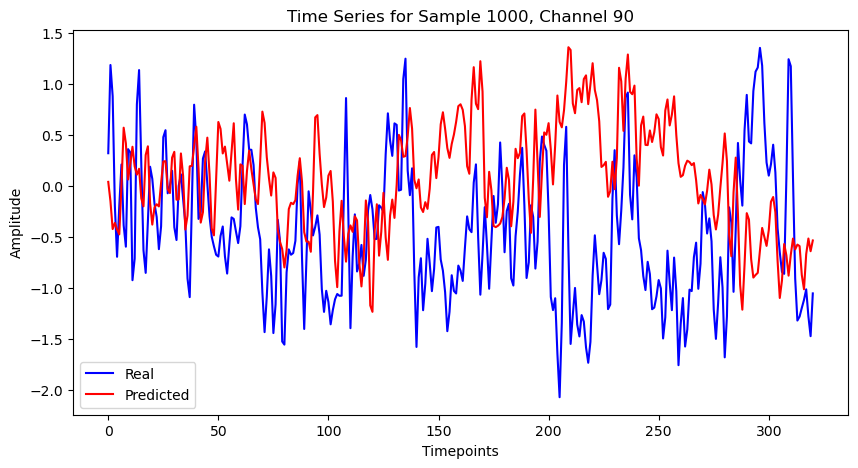

In [83]:
import matplotlib.pyplot as plt

sample = 1000
channel = 90
y_val_true = y_val.reshape(y_val.shape[0], 208, -1)
time_series_real = y_val_true[sample, channel, :]
time_series_pred = predict[sample, channel, :]

plt.figure(figsize=(10, 5))
plt.plot(time_series_real.cpu().numpy(), label='Real', color='blue')
plt.plot(time_series_pred.numpy(), label='Predicted', color='red')

plt.title(f'Time Series for Sample {1000}, Channel {90}')
plt.xlabel('Timepoints')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


In [76]:
voxels_scores.mean()

tensor(-0.4320, device='cuda:2')

In [ ]:
# TODO: Pearson Correlation rispetto a canali e timepoints (due cicli for)

## Fine tuned CLAP - Reconst. Model

In [4]:
def normalize_brain(brain_files):
    mean = brain_files.mean(dim=(0, 2), keepdim=True)  
    std = brain_files.std(dim=(0, 2), keepdim=True)    
    normalized_brain = (brain_files - mean) / (std + 1e-9) 
    normalized_brain = torch.clamp(normalized_brain, max=5)

    return normalized_brain

In [5]:
brain_train = normalize_brain(brain_train)
brain_test = normalize_brain(brain_test)

In [6]:
class AudioDataset(Dataset):
    def __init__(self, audio_files, brain_files):
        self.audio_files = audio_files
        self.labels = brain_files
        self.processor = ClapProcessor.from_pretrained('laion/clap-htsat-unfused')
        self.resampler = torchaudio.transforms.Resample(orig_freq=sampling_audio, new_freq=48000)

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio = self.audio_files[idx]
        audio_res = self.resampler(audio)
        label = self.labels[idx]
        inputs = self.processor(audios=audio_res, return_tensors="pt", sampling_rate=48000)
        return inputs['input_features'][0], label

In [7]:
train_dataset_full = AudioDataset(audio_train, brain_train)

train_size = int(0.8 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset_full, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

In [13]:
class CustomClapLSTMModel(nn.Module):
    def __init__(self, clap_model, hidden_dim=208, output_dim=(208, 321)):
        super(CustomClapLSTMModel, self).__init__()
        self.clap = clap_model
        # Freeze all CLAP layers except the last one
        for param in self.clap.parameters():
            param.requires_grad = False
        # self.clap.audio_encoder.layers[-1].blocks[-1].output.dense.requires_grad = True   # provare a fine-tunare tutto l'ultimo layer
        self.clap.audio_encoder.layers[-1].output = True
        
        # self.convt1d = nn.ConvTranspose1d(in_channels=768, out_channels=hidden_dim, kernel_size=5, stride=3, padding=1)
        self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_dim, num_layers=2, batch_first=True)
        self.fc = nn.AdaptiveAvgPool1d(output_dim[1])

    def forward(self, x):

        x = self.clap(x).last_hidden_state       # last_hidden_state shape is [batch, 768, 2, 32]
        batch_size, embd, time, freq = x.shape
        # x = x.view(batch_size, -1, embd)
        x = x.permute(0, 2, 3, 1)
        x = x.contiguous().view(batch_size, time*freq, embd)        # [batch, 768, 64]
        # x = self.convt1d(x)    # [batch, 208, 64]
        x, _ = self.lstm(x)
        x = x.permute(0, 2, 1)
        x = self.fc(x)
        
        return x

In [14]:
clap_model = ClapAudioModel.from_pretrained("laion/clap-htsat-unfused")
model = CustomClapLSTMModel(clap_model=clap_model).float()

Some weights of ClapAudioModel were not initialized from the model checkpoint at laion/clap-htsat-unfused and are newly initialized: ['audio_encoder.layers.2.blocks.1.attention.self.key.weight', 'audio_encoder.layers.2.blocks.0.attention.self.relative_position_bias_table', 'audio_encoder.layers.2.blocks.2.attention.self.relative_position_bias_table', 'audio_encoder.layers.2.blocks.1.attention.self.value.weight', 'audio_encoder.layers.2.blocks.3.layernorm_after.bias', 'audio_encoder.layers.3.blocks.0.attention.output.dense.bias', 'audio_encoder.layers.3.blocks.1.layernorm_before.bias', 'audio_encoder.layers.1.downsample.reduction.weight', 'audio_encoder.layers.2.blocks.4.attention.self.value.bias', 'audio_encoder.layers.1.blocks.1.attention.self.relative_position_bias_table', 'audio_encoder.layers.2.blocks.0.attention.self.query.weight', 'audio_encoder.layers.1.blocks.0.attention.output.dense.weight', 'audio_encoder.layers.2.blocks.4.attention.self.key.weight', 'audio_encoder.layers.2.b

In [15]:
def pearson_corr_loss(pred, target, device):
    
    pearson_channels = torch.zeros(208).to(device)
    reference = torch.ones(208).to(device)
    
    for channel in range(pred.shape[1]):
        
        pred_chann = pred[:,channel]
        target_chann = target[:,channel]

        pred_mean = torch.mean(pred_chann, dim=-1, keepdim=True)
        target_mean = torch.mean(target_chann, dim=-1, keepdim=True)
        
        pred_centered = pred_chann - pred_mean
        target_centered = target_chann - target_mean
        
        covariance = torch.sum(pred_centered * target_centered, dim=-1)
        pred_std = torch.sqrt(torch.sum(pred_centered ** 2, dim=-1))
        target_std = torch.sqrt(torch.sum(target_centered ** 2, dim=-1)) 
        correlation = covariance / (pred_std * target_std + 1e-9)  # Avoid division by zero
        pearson_channels[channel] = torch.mean(correlation)

    return torch.mean(reference - pearson_channels)


def hybrid_loss(pred, target, alpha, criterion):
    pre_loss = criterion(pred, target)
    corr_loss = pearson_corr_loss(pred, target)  
    return alpha * pre_loss + (1 - alpha) * corr_loss

In [ ]:
# optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)
optimizer = torch.optim.AdamW([
    {'params': model.clap.parameters(), 'lr': 1e-5},  # Small LR for pre-trained model
    {'params': model.lstm.parameters(), 'lr': 1e-4},  
    {'params': model.fc.parameters(), 'lr': 1e-4}     
])
criterion_mse = nn.MSELoss()  
criterion_smooth = nn.SmoothL1Loss()  

# Training loop
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()
epochs = 20

for epoch in range(epochs):  
    running_loss = 0.0

    for batch in tqdm(train_dataloader):
        inputs, labels = batch
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)

        outputs = model(inputs)
        loss = pearson_corr_loss(outputs, labels, device)   
        # loss = hybrid_loss(outputs, labels, 0.5, criterion_smooth)   

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for val_batch in tqdm(val_dataloader):
            val_inputs, val_labels = val_batch
            val_inputs = val_inputs.float().to(device)
            val_labels = val_labels.float().to(device)

            val_outputs = model(val_inputs)
            val_loss += pearson_corr_loss(val_outputs, val_labels, device).item()  
            # val_loss += hybrid_loss(val_outputs, val_labels, 0.5, criterion_smooth)

    print(f"Epoch {epoch+1}, Training Loss: {running_loss / len(train_dataloader)}, Validation Loss: {val_loss / len(val_dataloader)}")

    model.train()  # Set model back to training mode

In [ ]:
# 100%|██████████| 86/86 [02:59<00:00,  2.09s/it]
# Epoch 1, Training Loss: 0.9988281109998393, Validation Loss: 0.9974081225173418
# 100%|██████████| 86/86 [02:33<00:00,  1.78s/it]
# Epoch 2, Training Loss: 0.9950668659321097, Validation Loss: 0.9949718845445056
# 100%|██████████| 86/86 [02:40<00:00,  1.87s/it]
# Epoch 3, Training Loss: 0.9916873754456986, Validation Loss: 0.9928194423054539
# 100%|██████████| 86/86 [02:38<00:00,  1.84s/it]
# Epoch 4, Training Loss: 0.9885247481423755, Validation Loss: 0.9908949656541958
# 100%|██████████| 86/86 [02:44<00:00,  1.91s/it]
# Epoch 5, Training Loss: 0.9856139913547871, Validation Loss: 0.9893646011518877
# 100%|██████████| 86/86 [02:35<00:00,  1.81s/it]
# Epoch 6, Training Loss: 0.9829404097656871, Validation Loss: 0.9880704554014428
# 100%|██████████| 86/86 [03:04<00:00,  2.14s/it]
# Epoch 7, Training Loss: 0.9804174380246983, Validation Loss: 0.9870194335316502
# 100%|██████████| 86/86 [02:35<00:00,  1.81s/it]
# Epoch 8, Training Loss: 0.9780433191809543, Validation Loss: 0.9860793802627298
# 100%|██████████| 86/86 [02:53<00:00,  2.02s/it]
# Epoch 9, Training Loss: 0.9756489285202914, Validation Loss: 0.9852703192899394
# 100%|██████████| 86/86 [02:49<00:00,  1.97s/it]
# Epoch 10, Training Loss: 0.9734082561592723, Validation Loss: 0.9846173594164294


# NEXT STEP: TRY TO RECONSTRUCT THE PREDICTED SIGNAL AND COMPARE
